# Setup/Imports

In [37]:
%%capture
from src import StdDeviation, Mean, Iqr

drop_model = StdDeviation(
    file_path="../data/2023-02-18_penn_invitational_c.yaml", alpha=2.5
)

The code for the [`Drops`](../src/drops.py) class subclasses [`Results`](../utils/results.py) and is shown below:
```python
class Results:
    ...
    @property
    def teams(self) -> list[int]:
        ...
    @property
    def teams_data(self) -> list[dict[str, str | int]]:
        ...
    @property
    def events(self) -> list[str]:
        ...
    @property
    def trial_events(self) -> list[str]:
        ...
    @property
    def score_sum(self) -> dict[int, int]:
        ...
    @property
    def full_scores(self) -> dict[int, list[int]]:
        ...
    @property
    def averages(self) -> dict[int, float]:
        ...

```
```python
class Drops(Results):
    def drop(self) -> None:
        """Drops the "bombed" events from the scores"""
        ...
    def visualize(self) -> None:
        """Visualizes the data"""
        ...
    
```

## Average Score Per School
##### $\frac{1}{n} \cdot \sum ^n s_e$
*where $n$ is the number of events and $s_e$ is the score of event $e$*

In [38]:
print("Average score per school: ")
for i, (t_number, score) in enumerate(
    sorted(drop_model.averages.items(), key=lambda item: item[1])
):
    print(f"{i+1}. {drop_model.teams[t_number]}: {score}")

Average score per school: 
1. Adlai E. Stevenson High School Green: 8.347826086956522
2. West Windsor-Plainsboro High School North A: 9.173913043478262
3. Montgomery High School A: 10.08695652173913
4. William G. Enloe High School : 11.043478260869565
5. West Windsor-Plainsboro High School South A: 11.608695652173912
6. Ward Melville High School Varsity: 11.782608695652174
7. Great Neck South High School : 12.173913043478262
8. Syosset High School : 12.608695652173912
9. Lower Merion High School Goals: 12.826086956521738
10. Centennial High School : 13.434782608695652
11. Cumberland Valley High School X: 15.91304347826087
12. Harriton High School B: 16.130434782608695
13. Harriton High School A: 17.17391304347826
14. East Brunswick High School : 18.47826086956522
15. Cumberland Valley High School Y: 19.304347826086957
16. South Brunswick High School Eucalyptus: 19.304347826086957
17. John Jay High School A: 19.869565217391305
18. West Windsor-Plainsboro High School North B: 19.95652173

# Distinguishing "Bombed" Events
### Using the following methods to determine "bombed" events:
##### These values become the upper fence for the data
- Mean
- IQR
- Standard Deviation

##### We then take the $\sum{b_n}$ sum of bombed events of team $n$ and divide by $T$ (number of teams) to get the average number of "bombed" events per team. 
*These values can be adjusted via a multiplicative constant $\alpha$*

### [Mean Method](../src/mean.py)
#### $\alpha \cdot \overline{X}$
*where $\overline{X}$ is the mean of the data and $\alpha$ is a multiplicative constant*

In [39]:
%%capture
# redefine our model to use this method
mean_model = Mean(file_path="../data/2023-05-20_nationals_c.yaml", alpha=2)
mean_model.drop()

### [IQR Method - Standard Outlier Formula](../src/iqr.py)
#### $\alpha \cdot (Q_3 - Q_1) + Q_3$ &nbsp; (IQR)
*where $Q_3$ is the third quartile and $Q_1$ is the first quartile*
*Here we follow the standard outlier formula where $\alpha \equals 1.5$*

In [40]:
%%capture
# redefine our model to use this method
iqr_model = Iqr(file_path="../data/2023-05-20_nationals_c.yaml", alpha=1.5)
iqr_model.drop()

### [Standard Deviation Method](../src/stddeviation.py) 
#### $\alpha \cdot \sigma + \overline{X} $
*$\sigma$ is the standard deviation of the data, $\overline{X}$ is the mean of the data, and $\alpha$ is a multiplicative constant*

In [41]:
%%capture
# redefine our model to use this method
std_dev_model = StdDeviation(file_path="../data/2023-05-20_nationals_c.yaml", alpha=1.5)
std_dev_model.drop()

## Consistent Flaws
All of these methods are too sensitive to "top" teams while do not account nearly as well for lower ranked teams. A possible solution would be a scalar multiplier based on the team's rank. This would have a greater account for bombs even when the mean/median place on a team is lower. 

## Calculating Bombed Events
Using the standard deviation method with $\alpha = 1.5$ to determine "bombed" events as a demonstration


In [42]:
%%capture
std_dev_model = StdDeviation(
    file_path="../data/2023-02-18_penn_invitational_c.yaml", alpha=1.5
)
std_dev_model.drop()

In [43]:
for school, events in std_dev_model.bombed_events.items():
    print(f"{std_dev_model.teams[school]}: [{', '.join(events) if events else 'None'}]")

Adlai E. Stevenson High School Green: [Fermi Questions, Scrambler, Trajectory]
Adlai E. Stevenson High School Gold: [Flight, WiFi Lab]
Allentown Central Catholic High School Gold: [None]
Allentown Central Catholic High School Green: [None]
Bayard Rustin High School Blue: [Cell Biology, Environmental Chemistry, Fermi Questions]
Bayard Rustin High School Gold: [None]
Centennial High School : [Rocks and Minerals]
Central High School : [None]
Cherry Hill High School East 1: [Flight, Forensics]
Cherry Hill High School East 2: [None]
Chaminade High School Flyers: [Remote Sensing]
Ed W. Clark High School Gold: [Write It Do It]
Ed W. Clark High School Orange: [Cell Biology]
Columbia High School White: [Anatomy and Physiology, Cell Biology]
Cumberland Valley High School X: [Chemistry Lab, Trajectory, Write It Do It]
Cumberland Valley High School Y: [Codebusters, Trajectory]
East Brunswick High School : [It's About Time, Forestry]
Fairfax High School Blue: [Forestry]
Fairfax High School Gray: [A

## Recalculating scores/ranking with auto drop "bombed" events
### Dropping $\lfloor{\frac{\sum_n^k{b_n}}{T}}\rfloor$ (avg) "bombed" events from each team's scores

In [44]:
print(f"After dropping {std_dev_model.to_drop} events:")
for i, (t_number, score) in enumerate(std_dev_model.dropped_scores.items()):
    print(f"{i+1}. {std_dev_model.teams[t_number]}: {score}")

After dropping 1 events:
1. Adlai E. Stevenson High School Green: 163
2. West Windsor-Plainsboro High School North A: 186
3. Montgomery High School A: 204
4. West Windsor-Plainsboro High School South A: 225
5. William G. Enloe High School : 228
6. Great Neck South High School : 241
7. Ward Melville High School Varsity: 241
8. Syosset High School : 262
9. Lower Merion High School Goals: 265
10. Centennial High School : 280
11. Harriton High School B: 319
12. Cumberland Valley High School X: 326
13. Harriton High School A: 359
14. East Brunswick High School : 378
15. South Brunswick High School Eucalyptus: 397
16. West Windsor-Plainsboro High School North B: 402
17. Cumberland Valley High School Y: 408
18. John Jay High School A: 409
19. Montgomery High School B: 417
20. Chaminade High School Flyers: 451
21. West Windsor-Plainsboro High School South B: 458
22. Adlai E. Stevenson High School Gold: 461
23. Penncrest High School : 468
24. Northridge High School Green: 498
25. Columbia High 

# Visualization of Data
We can see overall placement changes between teams as well as an overall trend as to how dropping affects the shape of the relationship/curve between teams and their scores.

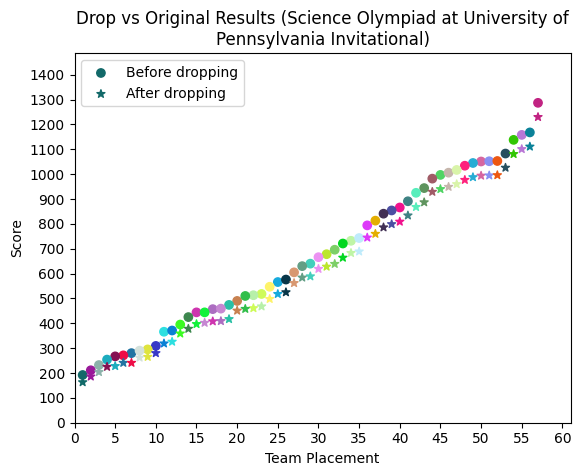

In [45]:
std_dev_model.visualize()